<a href="https://colab.research.google.com/github/iam-pattan/DL/blob/master/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8l47xh0w
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8l47xh0w
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=4f85daab43d13e778162a4748b1f83af8678f6e42b59436a716e7fd6f4c0cd09
  Stored in directory: /tmp/pip-ephem-wheel-cache-a05o09aa/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [3]:
# installation for google-images-download
# !pip install git+https://github.com/Joeclinton1/google-images-download.git

# from google_images_download import google_images_download   
# # creating object
# response = google_images_download.googleimagesdownload() 
# arguments = {"keywords":"cat, dog","limit":5,"print_urls":True}   #creating list of arguments
# paths = response.download(arguments)   #passing the arguments to the function
# print(paths) 

In [11]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [12]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [19]:
!gdown --id 1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU

Downloading...
From: https://drive.google.com/uc?id=1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU
To: /content/sandstone_data_for_ML.zip
450MB [00:03, 121MB/s]


In [ ]:
!unzip /content/sandstone_data_for_ML.zip

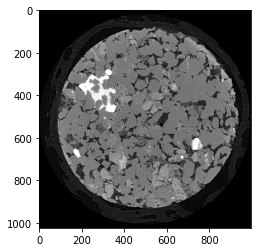

In [213]:
_img = plt.imread('/content/sandstone_data_for_ML/sandstone_all_462_images.tif')
_img.shape
plt.imshow(_img, cmap='gray')

(256, 256) (256, 256)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3d8ad6df90>,
 <matplotlib.image.AxesImage at 0x7f3d8ad38fd0>)

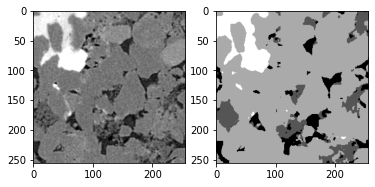

In [212]:
train_img = plt.imread('/content/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
msk_img = plt.imread('/content/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')

print(train_img.shape, msk_img.shape)
plt.subplot(121), plt.imshow(train_img, cmap='gray')
plt.subplot(122),plt.imshow(msk_img, cmap='gray')

### Not working because TIFF file has to work with diff. libraries

In [218]:
from patchify import patchify

image_to_patch = train_img
patches = patchify(image_to_patch, (32,32), step=16)

In [222]:
patches.shape

(15, 15, 32, 32)

In [240]:
!mkdir /content/train

In [243]:
!cd /content/train/

In [249]:
for i in range(15):
  for j in range(15):
    name = str(i + j)
    plt.imsave('/content/train/'+name, patches[i][j], format='jpg')

## U-net code 


In [170]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []
train_masks = []

In [171]:
for directory_path in glob.glob("/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [172]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [173]:
train_images.shape, train_masks_input.shape

((1, 128, 128, 3), (1, 128, 128, 1))

In [177]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images[0], train_masks_input[0], test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [178]:
y_train_cat.shape

(57, 128, 1, 4)

In [179]:
n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [182]:
X_train.shape, X_test.shape, X_train1.shape, X_test1.shape

((57, 128, 3), (13, 128, 3), (57, 128, 3), (13, 128, 3))

In [183]:
#Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_544 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_544[0][0]         
___________________________________________________________________________________________

ValueError: ignored

In [ ]:
#Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('inceptionv3_backbone_50epochs.hdf5')

In [ ]:
#Model 3

BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())

history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))


model3.save('vgg19_backbone_50epochs.hdf5')


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('saved_models/res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred1=model2.predict(X_test2)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')